In [11]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")


✓ Libraries imported successfully
TensorFlow version: 2.20.0


In [13]:
# Cell 2: Load and Explore Data
print("="*70)
print("LOADING DATA")
print("="*70)

# DataFrame 'df' is already loaded, so we skip loading from CSV.
# df = pd.read_csv('data/aapl_stock.csv')

# Ensure numeric types
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nLast 5 rows:")
print(df.tail())
print(f"\nBasic statistics:")
print(df['Close'].describe())

LOADING DATA

Dataset shape: (1509, 6)

Column names: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']

First 5 rows:
        Price      Close       High        Low       Open       Volume
2  2018-01-02  40.381001  40.390379  39.677744  39.888723  102223600.0
3  2018-01-03  40.373962  40.917816  40.310672  40.444289  118071600.0
4  2018-01-04  40.561504  40.664649  40.338807  40.446638   89738400.0
5  2018-01-05  41.023300  41.110034  40.566184  40.657607   94640000.0
6  2018-01-08  40.870926  41.166292  40.772467  40.870926   82271200.0

Last 5 rows:
           Price       Close        High         Low        Open      Volume
1506  2023-12-22  191.974670  193.769472  191.349955  193.541392  37149600.0
1507  2023-12-26  191.429291  192.262235  191.211137  191.984587  28919300.0
1508  2023-12-27  191.528442  191.875510  189.485739  190.873995  48087700.0
1509  2023-12-28  191.954865  193.025800  191.548303  192.510161  34049900.0
1510  2023-12-29  190.913651  192.767946  190.120364  

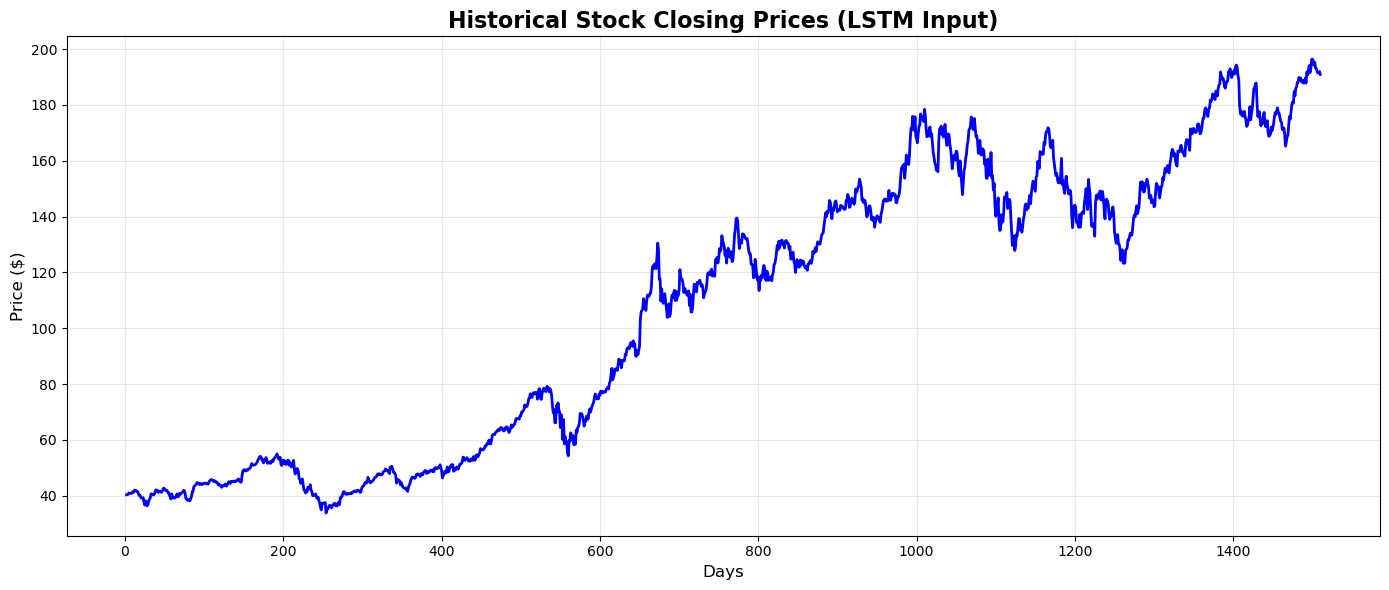

In [14]:
# Cell 3: Visualize Data
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], linewidth=2, color='blue')
plt.title('Historical Stock Closing Prices (LSTM Input)', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Cell 4: Prepare Data for LSTM
print("\n" + "="*70)
print("PREPARING DATA FOR LSTM")
print("="*70)

# Use only Close price
close_data = df['Close'].values.reshape(-1, 1)
print(f"\nClose data shape: {close_data.shape}")

# Scale data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

print(f"Scaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")

# Split into train/test (80/20)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Include 60 days for first sequence

print(f"\nTrain data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")


PREPARING DATA FOR LSTM

Close data shape: (1509, 1)
Scaled data range: [0.0000, 1.0000]

Train data size: 1207
Test data size: 362


In [16]:
# Cell 5: Create Sequences
print("\n" + "="*70)
print("CREATING SEQUENCES")
print("="*70)

def create_sequences(data, sequence_length=60):
    """
    Create sequences for LSTM training.
    Each sequence contains 'sequence_length' time steps to predict the next value.
    """
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    
    return np.array(X), np.array(y)

# Set sequence length (number of days to look back)
sequence_length = 60
print(f"\nUsing {sequence_length} days to predict next day")

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape for LSTM input: [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nReshaped X_train: {X_train.shape}")
print(f"Reshaped X_test: {X_test.shape}")



CREATING SEQUENCES

Using 60 days to predict next day

X_train shape: (1147, 60)
y_train shape: (1147,)
X_test shape: (302, 60)
y_test shape: (302,)

Reshaped X_train: (1147, 60, 1)
Reshaped X_test: (302, 60, 1)


In [17]:
# Cell 6: Build LSTM Model
print("\n" + "="*70)
print("BUILDING LSTM MODEL")
print("="*70)

# Create model
model = Sequential([
    # First LSTM layer
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    # Output layer
    Dense(units=1)
])

# Compile model
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Display model architecture
print("\nModel Architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")


BUILDING LSTM MODEL

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 30,651


In [18]:
# Cell 7: Setup Training Callbacks
print("\n" + "="*70)
print("SETTING UP TRAINING CALLBACKS")
print("="*70)

# Early stopping - stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when learning plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stop, reduce_lr]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=10)")
print("  - Learning Rate Reduction (patience=5)")



SETTING UP TRAINING CALLBACKS
✓ Callbacks configured:
  - Early Stopping (patience=10)
  - Learning Rate Reduction (patience=5)


In [19]:
# Cell 8: Train LSTM Model
print("\n" + "="*70)
print("TRAINING LSTM MODEL")
print("="*70)

# Train model
print("\nStarting training...\n")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")



TRAINING LSTM MODEL

Starting training...

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0399 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0035 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0030 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0026 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0024 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0022 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0022 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0020 - val_loss: 0.0020

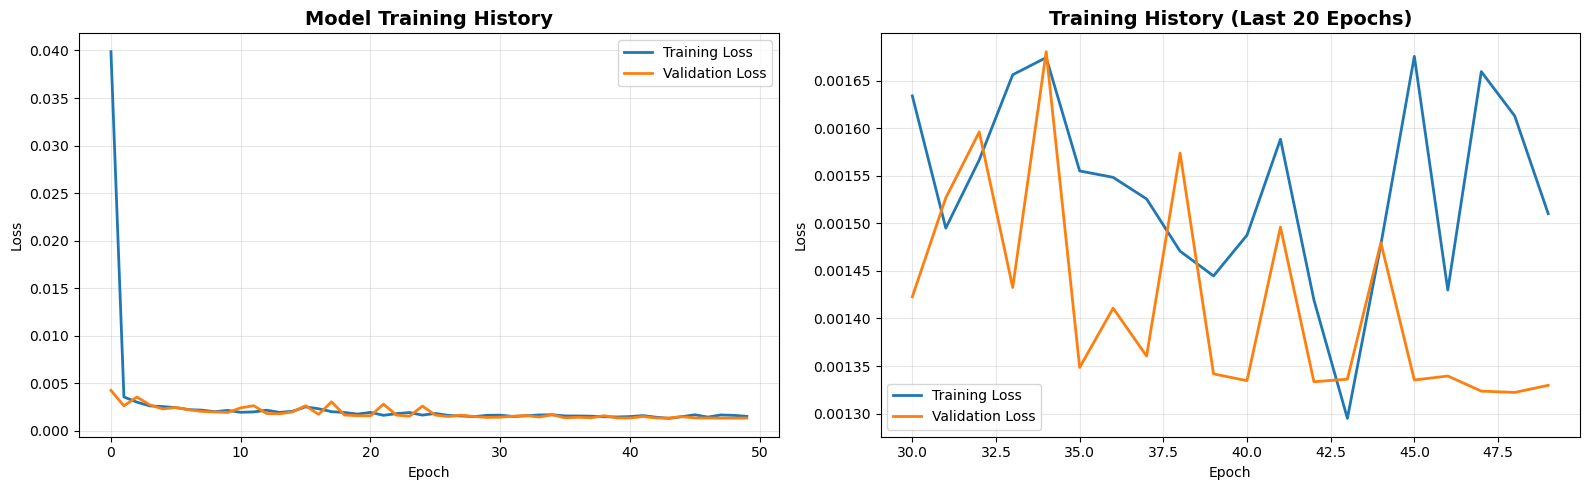


Final Training Loss: 0.001510
Final Validation Loss: 0.001330


In [20]:
# Cell 9: Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Training History', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot zoomed view (last 20 epochs)
start_epoch = max(0, len(history.history['loss']) - 20)
axes[1].plot(range(start_epoch, len(history.history['loss'])), 
             history.history['loss'][start_epoch:], 
             label='Training Loss', linewidth=2)
axes[1].plot(range(start_epoch, len(history.history['val_loss'])), 
             history.history['val_loss'][start_epoch:], 
             label='Validation Loss', linewidth=2)
axes[1].set_title('Training History (Last 20 Epochs)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {history.history['loss'][-1]:.6f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.6f}")


In [21]:
# Cell 10: Make Predictions
print("\n" + "="*70)
print("MAKING PREDICTIONS")
print("="*70)

# Predict on train and test sets
print("\nPredicting on training set...")
train_predictions = model.predict(X_train, verbose=0)

print("Predicting on test set...")
test_predictions = model.predict(X_test, verbose=0)

# Inverse transform to get actual prices
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("\n✓ Predictions complete!")
print(f"\nSample predictions (first 5):")
for i in range(min(5, len(y_test_actual))):
    print(f"  Actual: ${y_test_actual[i][0]:.2f}, Predicted: ${test_predictions[i][0]:.2f}")



MAKING PREDICTIONS

Predicting on training set...
Predicting on test set...

✓ Predictions complete!

Sample predictions (first 5):
  Actual: $141.52, Predicted: $138.78
  Actual: $141.62, Predicted: $138.75
  Actual: $141.16, Predicted: $138.91
  Actual: $144.98, Predicted: $139.16
  Actual: $147.13, Predicted: $139.70


In [22]:
# Cell 11: Evaluate Model Performance
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Calculate metrics for training set
train_mse = mean_squared_error(y_train_actual, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_actual, train_predictions)
train_r2 = r2_score(y_train_actual, train_predictions)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test_actual, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_actual, test_predictions)
test_r2 = r2_score(y_test_actual, test_predictions)

# Display results
print("\nTraining Set Performance:")
print(f"  MSE:  {train_mse:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

print("\nTest Set Performance:")
print(f"  MSE:  {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")

# Interpret results
print("\nInterpretation:")
print(f"  - Model explains {test_r2*100:.2f}% of variance in test data")
print(f"  - Average prediction error: ${test_mae:.2f}")
print(f"  - Predictions are off by ~${test_rmse:.2f} on average (RMSE)")



MODEL EVALUATION

Training Set Performance:
  MSE:  15.2271
  RMSE: 3.9022
  MAE:  2.7554
  R²:   0.9926

Test Set Performance:
  MSE:  32.8240
  RMSE: 5.7292
  MAE:  4.9493
  R²:   0.9141

Interpretation:
  - Model explains 91.41% of variance in test data
  - Average prediction error: $4.95
  - Predictions are off by ~$5.73 on average (RMSE)


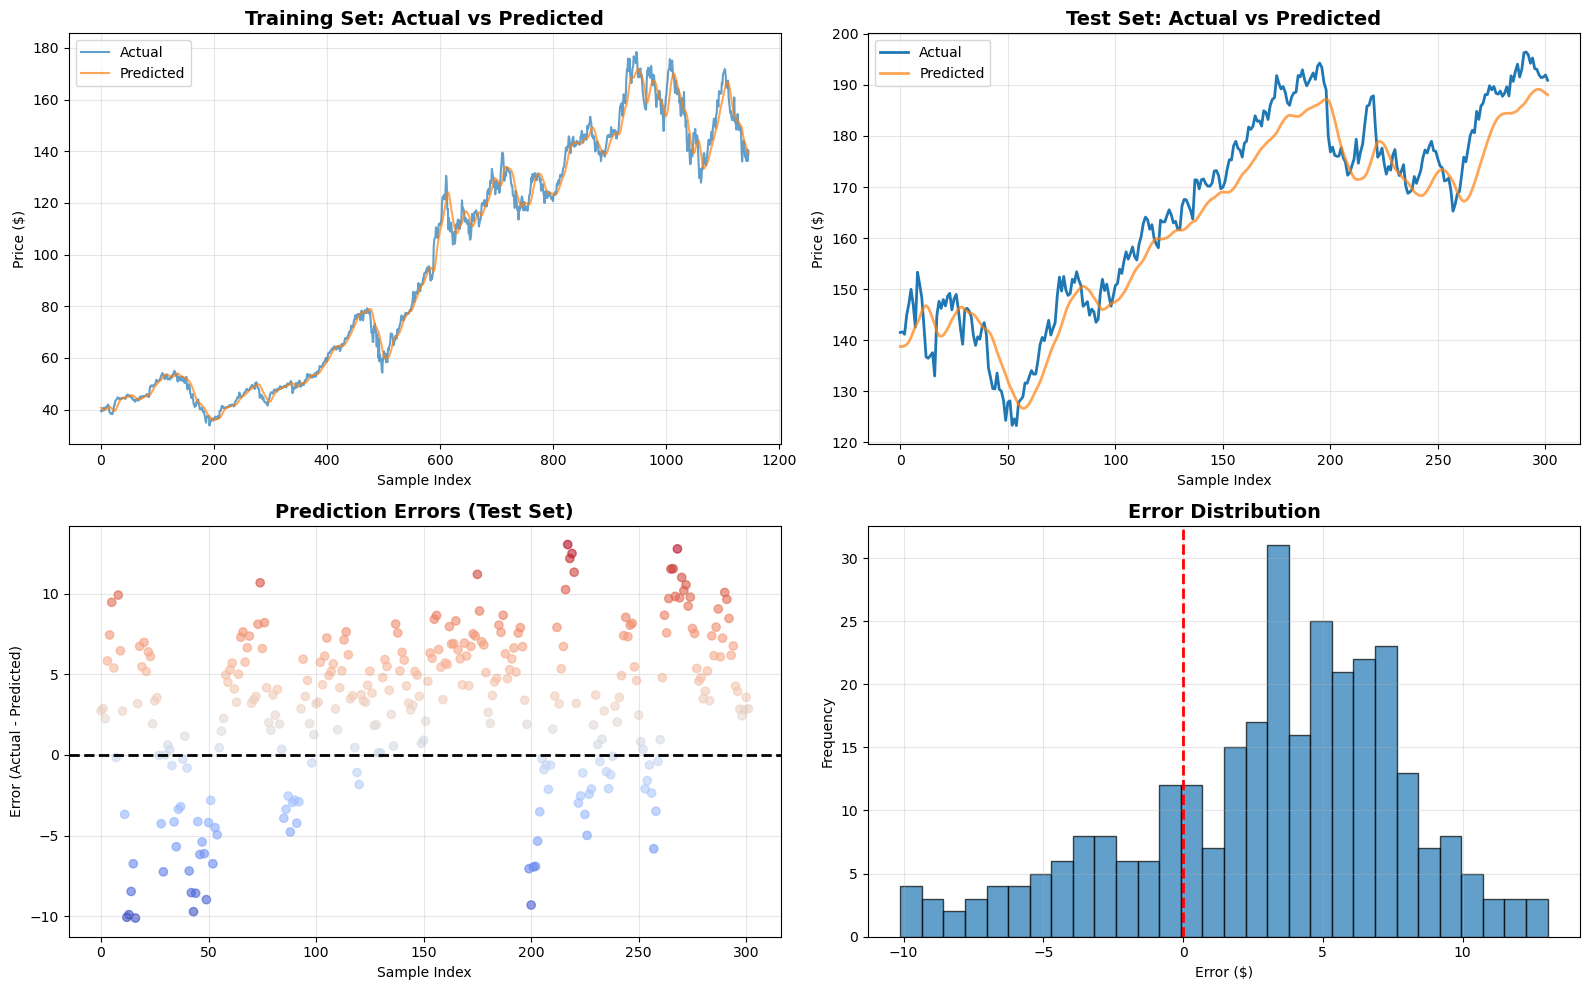

In [26]:
# Cell 12: Visualize Predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
# Plot 1: Training Set Predictions
axes[0, 0].plot(y_train_actual, label='Actual', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(train_predictions, label='Predicted', alpha=0.7, linewidth=1.5)
axes[0, 0].set_title('Training Set: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# Plot 2: Test Set Predictions
axes[0, 1].plot(y_test_actual, label='Actual', linewidth=2)
axes[0, 1].plot(test_predictions, label='Predicted', linewidth=2, alpha=0.7)
axes[0, 1].set_title('Test Set: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction Errors
test_errors = y_test_actual.flatten() - test_predictions.flatten()
axes[1, 0].scatter(range(len(test_errors)), test_errors, alpha=0.6, 
                   c=test_errors, cmap='coolwarm')
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_title('Prediction Errors (Test Set)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Error (Actual - Predicted)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error Distribution
axes[1, 1].hist(test_errors, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Error ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Cell 13: Detailed Error Analysis
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

print(f"\nError Statistics:")
print(f"  Mean Error:     {test_errors.mean():.4f}")
print(f"  Std Error:      {test_errors.std():.4f}")
print(f"  Min Error:      {test_errors.min():.4f}")
print(f"  Max Error:      {test_errors.max():.4f}")
print(f"  Median Error:   {np.median(test_errors):.4f}")

# Percentage of predictions within thresholds
within_1 = np.sum(np.abs(test_errors) <= 1) / len(test_errors) * 100
within_2 = np.sum(np.abs(test_errors) <= 2) / len(test_errors) * 100
within_5 = np.sum(np.abs(test_errors) <= 5) / len(test_errors) * 100

print(f"\nPrediction Accuracy:")
print(f"  Within $1:  {within_1:.1f}%")
print(f"  Within $2:  {within_2:.1f}%")
print(f"  Within $5:  {within_5:.1f}%")


ERROR ANALYSIS

Error Statistics:
  Mean Error:     3.0766
  Std Error:      4.8331
  Min Error:      -10.1158
  Max Error:      13.0410
  Median Error:   3.7116

Prediction Accuracy:
  Within $1:  9.9%
  Within $2:  16.6%
  Within $5:  53.3%


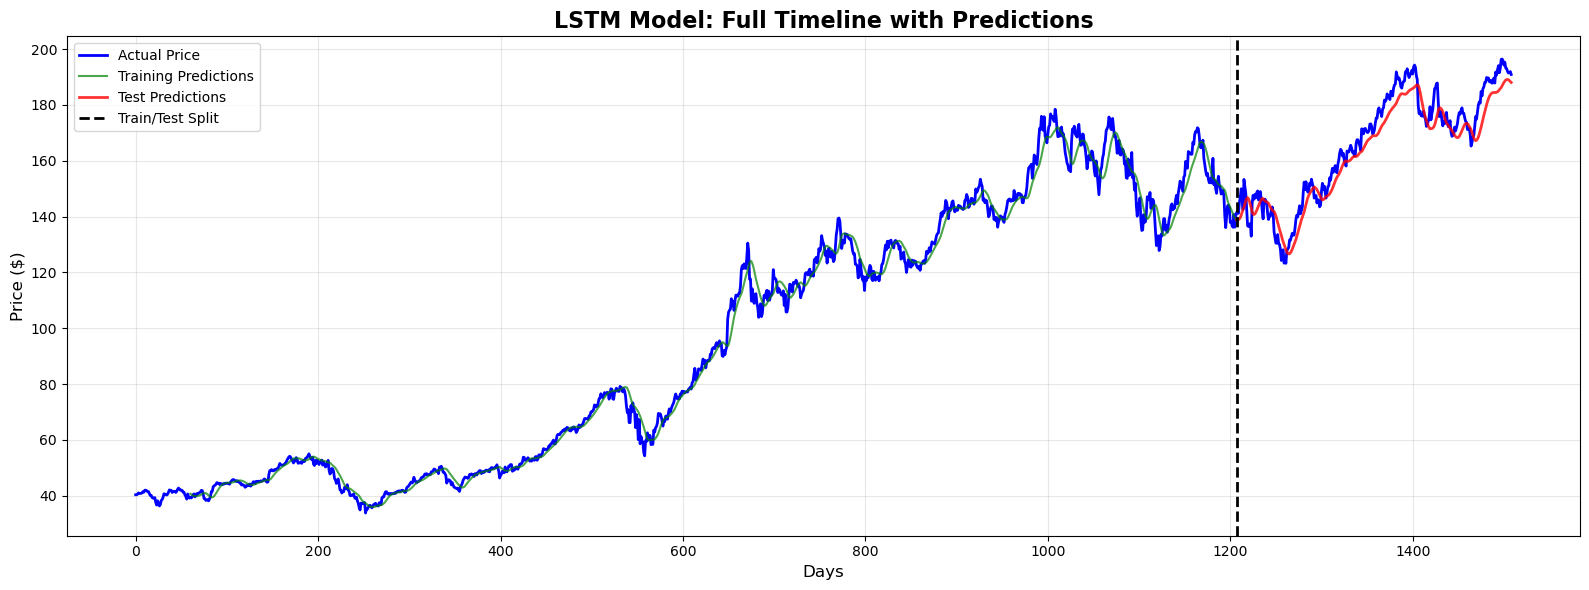

In [28]:
# Cell 14: Full Timeline Visualization
plt.figure(figsize=(16, 6))

# Plot training predictions
train_plot = np.empty_like(close_data)
train_plot[:, :] = np.nan
train_plot[sequence_length:sequence_length+len(train_predictions), :] = train_predictions

# Plot test predictions
test_plot = np.empty_like(close_data)
test_plot[:, :] = np.nan
test_plot[len(train_data):len(train_data)+len(test_predictions), :] = test_predictions

# Plot everything
plt.plot(close_data, label='Actual Price', linewidth=2, color='blue')
plt.plot(train_plot, label='Training Predictions', linewidth=1.5, alpha=0.7, color='green')
plt.plot(test_plot, label='Test Predictions', linewidth=2, alpha=0.8, color='red')
plt.axvline(x=train_size, color='black', linestyle='--', linewidth=2, label='Train/Test Split')
plt.title('LSTM Model: Full Timeline with Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Cell 15: Summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print("\n✅ LSTM Model Complete!")
print("\nModel Configuration:")
print(f"  • Architecture: 2 LSTM layers (50 units each) + Dropout (0.2)")
print(f"  • Sequence Length: {sequence_length} days")
print(f"  • Training Samples: {len(X_train)}")
print(f"  • Test Samples: {len(X_test)}")
print(f"  • Total Parameters: {total_params:,}")

print("\nPerformance Metrics:")
print(f"  • Test RMSE: ${test_rmse:.4f}")
print(f"  • Test MAE: ${test_mae:.4f}")
print(f"  • Test R² Score: {test_r2:.4f}")
print(f"  • Variance Explained: {test_r2*100:.2f}%")

print("\nModel Quality:")
if test_r2 > 0.95:
    print("  🎉 Excellent model performance!")
elif test_r2 > 0.90:
    print("  👍 Good model performance!")
else:
    print("  ⚠️  Model could be improved")

print("\nKey Insights:")
print(f"  • LSTM captures long-term dependencies in stock prices")
print(f"  • {within_2:.1f}% of predictions within $2 of actual price")
print(f"  • Model trained for {len(history.history['loss'])} epochs")

print("="*70)


SUMMARY

✅ LSTM Model Complete!

Model Configuration:
  • Architecture: 2 LSTM layers (50 units each) + Dropout (0.2)
  • Sequence Length: 60 days
  • Training Samples: 1147
  • Test Samples: 302
  • Total Parameters: 30,651

Performance Metrics:
  • Test RMSE: $5.7292
  • Test MAE: $4.9493
  • Test R² Score: 0.9141
  • Variance Explained: 91.41%

Model Quality:
  👍 Good model performance!

Key Insights:
  • LSTM captures long-term dependencies in stock prices
  • 16.6% of predictions within $2 of actual price
  • Model trained for 50 epochs
